References:
    * https://www.kaggle.com/vukglisovic/classification-combining-lda-and-word2vec# 

## Load

In [1]:
import pandas as pd
data = pd.read_csv('dataset.tsv', sep='\t', index_col=0)

In [ ]:
data.clean_text = data.clean_text.apply(eval)
data.bow = data.bow.apply(eval)
data.entities = data.entities.apply(eval)

In [28]:
sentences = []
for sentence_group in data.clean_text:
    sentences.extend([sentence_group])

print("Number of sentences: {}.".format(len(sentences)))
print("Number of texts: {}.".format(len(data)))

Number of sentences: 3305.
Number of texts: 3305.


## W2V features

In [29]:
from gensim.models import Word2Vec

In [30]:
# Set values for various parameters
num_features = 200    # Word vector dimensionality
min_word_count = 1    # Minimum word count
num_workers = 4       # Number of threads to run in parallel
context = 6           # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model
W2Vmodel = Word2Vec(sentences=sentences,
                    sg=1,
                    hs=0,
                    workers=num_workers,
                    size=num_features,
                    min_count=min_word_count,
                    window=context,
                    sample=downsampling,
                    negative=5,
                    iter=6)

In [31]:
len(W2Vmodel.wv.vocab)

1882

In [226]:
def get_w2v_features(w2v_model, sentence_group):
    """ Transform a sentence_group (containing multiple lists
    of words) into a feature vector. It averages out all the
    word vectors of the sentence_group.
    """
    try:
        words = sentence_group  # words in text
    except:
        print(sentence_group)
        words = np.concatenate([['']])  # words in text
    index2word_set = set(w2v_model.wv.vocab.keys())  # words known to model
    
    featureVec = np.zeros(w2v_model.vector_size, dtype="float32")
    
    # Initialize a counter for number of words in a review
    nwords = 0
    # Loop over each word in the comment and, if it is in the model's vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            featureVec = np.add(featureVec, w2v_model.wv[word])
            nwords += 1.

    # Divide the result by the number of words to get the average
    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

In [227]:
data['w2v_features'] = list(map(lambda sen_group:
                                      get_w2v_features(W2Vmodel, sen_group),
                                      data.text))

## Clustering

In [34]:
K = len(data['intent'].unique())

In [35]:
X = np.array(list(map(np.array, data.w2v_features)))
y = data['intent']

In [36]:
X.shape, y.shape

((3305, 200), (3305,))

---

In [37]:
from sklearn.cluster import KMeans, AgglomerativeClustering

In [89]:
from sklearn.mixture import GaussianMixture

In [38]:
km = KMeans(K).fit(X)

In [87]:
km = AgglomerativeClustering(K).fit(X)

In [93]:
km = GaussianMixture(K, tol=1e-6, max_iter=500).fit(X)

---

In [39]:
comp = pd.DataFrame(data[['text', 'intent']])

In [40]:
comp['clusters'] = km.predict(X)

In [41]:
comp['clusters'] = km.labels_

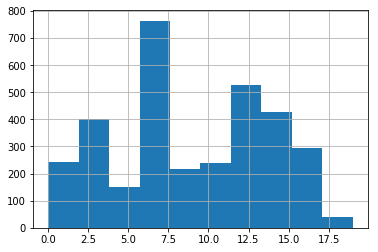

In [96]:
comp['clusters'].hist().get_figure().savefig('w2v/figure.pdf')

In [124]:
r = pd.pivot_table(comp, index='intent', columns='clusters', aggfunc=len, fill_value=0)\
            .style.background_gradient(axis=1)

In [125]:
r

In [44]:
from sklearn.metrics import *

In [45]:
def purity_score(y_true, y_pred):
    contingency_matrix = cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

## GO

10 features
	 KMeans
	 AgglomerativeClustering
	 GaussianMixture
20 features
	 KMeans
	 AgglomerativeClustering
	 GaussianMixture
30 features
	 KMeans
	 AgglomerativeClustering
	 GaussianMixture
50 features
	 KMeans
	 AgglomerativeClustering
	 GaussianMixture
100 features
	 KMeans
	 AgglomerativeClustering
	 GaussianMixture
150 features
	 KMeans
	 AgglomerativeClustering
	 GaussianMixture
200 features
	 KMeans
	 AgglomerativeClustering
	 GaussianMixture
300 features
	 KMeans
	 AgglomerativeClustering
	 GaussianMixture
400 features
	 KMeans
	 AgglomerativeClustering
	 GaussianMixture
500 features
	 KMeans
	 AgglomerativeClustering
	 GaussianMixture
550 features
	 KMeans
	 AgglomerativeClustering
	 GaussianMixture
600 features
	 KMeans
	 AgglomerativeClustering
	 GaussianMixture


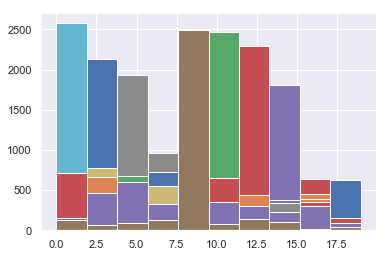

In [345]:
raw_results = []
cms = []
np.random.seed(0)

for num_features in [10, 20, 30, 50, 100, 150, 200, 300, 400, 500, 550, 600]:
    W2Vmodel = Word2Vec(sentences=sentences,
                        sg=1,
                        hs=0,
                        workers=num_workers,
                        size=num_features,
                        min_count=min_word_count,
                        window=context,
                        sample=downsampling,
                        negative=5,
                        iter=6)
    
    data['w2v_features'] = list(map(lambda sen_group:
                                      get_w2v_features(W2Vmodel, sen_group),
                                      data.text))
    X = np.array(list(map(np.array, data.w2v_features)))
    print('%d features'%num_features)
    for model in [KMeans, AgglomerativeClustering, GaussianMixture]:
        print('\t %s'%str(model).split('.')[-1][:-2])
        try:
            km = model(K, tol=1e-6, max_iter=500).fit(X)
        except:
            km = model(K).fit(X)


        comp = pd.DataFrame(data[['text', 'intent']])
        try:
            comp['clusters'] = km.labels_
        except:
            comp['clusters'] = km.predict(X)

        comp['clusters'].hist().get_figure().savefig('w2v/hist_%d.pdf'%num_features)
        cms += [pd.pivot_table(comp, index='intent', columns='clusters', aggfunc=len, fill_value=0)\
                    .style.background_gradient(axis=1)]
        raw_results += [(
            purity_score(comp['intent'], comp['clusters']),
            silhouette_score(X, comp['clusters']),
            homogeneity_score(comp['intent'], comp['clusters']),
            completeness_score(comp['intent'], comp['clusters']),
            num_features,
            str(model).split('.')[-1][:-2])
        ]

In [346]:
results = pd.DataFrame(raw_results,
                       columns=['purity', 'silhouette', 'homogeneity', 
                                'completeness', 'features num', 'model'])


In [347]:
results['AVG'] = results[results.columns.difference(['model', 'features num'])].apply(np.mean, axis=1)

In [348]:
import seaborn as sns; sns.set()

In [349]:
results.to_csv('w2v/scores.csv')

In [350]:
results.style.background_gradient(axis=0)

,purity,silhouette,homogeneity,completeness,features num,model,AVG
0,0.174584,0.158933,0.0906473,0.10083,10,KMeans,0.131249
1,0.173676,0.114296,0.0915972,0.106045,10,AgglomerativeClustering,0.121404
2,0.227837,-0.0410188,0.144039,0.17614,10,GaussianMixture,0.126749
3,0.171256,0.165006,0.0919533,0.104825,20,KMeans,0.13326
4,0.170953,0.102711,0.0916479,0.102164,20,AgglomerativeClustering,0.116869
5,0.216641,-0.0838354,0.142663,0.174885,20,GaussianMixture,0.112588
6,0.163994,0.148454,0.0907468,0.100665,30,KMeans,0.125965
7,0.163994,0.142967,0.0915881,0.111835,30,AgglomerativeClustering,0.127596
8,0.224206,-0.102299,0.143209,0.174068,30,GaussianMixture,0.109796
9,0.163994,0.155801,0.0931332,0.103823,50,KMeans,0.129188


In [351]:
results[results['model']=='KMeans'].style.background_gradient(axis=0)

,purity,silhouette,homogeneity,completeness,features num,model,AVG
0,0.174584,0.158933,0.0906473,0.10083,10,KMeans,0.131249
3,0.171256,0.165006,0.0919533,0.104825,20,KMeans,0.13326
6,0.163994,0.148454,0.0907468,0.100665,30,KMeans,0.125965
9,0.163994,0.155801,0.0931332,0.103823,50,KMeans,0.129188
12,0.166112,0.185697,0.0929174,0.106432,100,KMeans,0.13779
15,0.164599,0.191461,0.0909775,0.101573,150,KMeans,0.137153
18,0.167625,0.195579,0.0900414,0.0982572,200,KMeans,0.137876
21,0.168533,0.217506,0.0915858,0.100371,300,KMeans,0.144499
24,0.161271,0.214482,0.0899613,0.0977892,400,KMeans,0.140876
27,0.162481,0.225334,0.0935782,0.102461,500,KMeans,0.145964


In [352]:
results.groupby('features num').mean().style.background_gradient(axis=0)

,purity,silhouette,homogeneity,completeness,AVG
features num,,,,,
10,0.192032,0.0774036,0.108761,0.127672,0.126467
20,0.186283,0.061294,0.108755,0.127291,0.120906
30,0.184065,0.0630405,0.108515,0.128856,0.121119
50,0.17761,0.0662788,0.107623,0.128358,0.119967
100,0.184266,0.0653807,0.109944,0.144074,0.125916
150,0.178417,0.0566761,0.105809,0.138289,0.119798
200,0.179929,0.0496567,0.102913,0.139742,0.11806
300,0.176803,0.0505959,0.105242,0.150409,0.120762
400,0.169844,0.072453,0.0984974,0.144132,0.121231


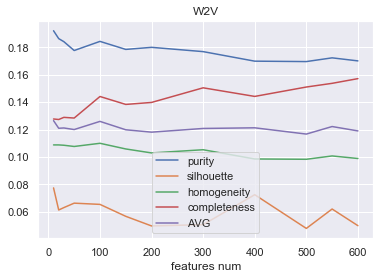

In [354]:
results.groupby('features num').mean().plot(title='W2V')

In [359]:
cms[12]

## Quick easy classifier

- 10 fold cross validation on 100 examples from labelled data
- Feed forward network
- Input = sequence of word representations

In [240]:
W2Vmodel = Word2Vec(sentences=sentences,
                    sg=1,
                    hs=0,
                    workers=num_workers,
                    size=550,
                    min_count=min_word_count,
                    window=context,
                    sample=downsampling,
                    negative=5,
                    iter=6)

data['w2v_features'] = list(map(lambda sen_group:
                                  get_w2v_features(W2Vmodel, sen_group),
                                  data.text))
X = np.array(list(map(np.array, data.w2v_features)))


In [299]:
y.index = pd.Index(list(range(0,len(y))))

In [302]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

def balanced_sample_maker(X, y, sample_size=None, random_seed=42):
    uniq_levels = np.unique(y)
    uniq_counts = {level: sum(y == level) for level in uniq_levels}

    if not sample_size:
        sample_size = round(min(uniq_counts.values()) * 0.8)
    
    if not random_seed is None:
        np.random.seed(random_seed)

    # find observation index of each class levels
    groupby_levels = {}
    for ii, level in enumerate(uniq_levels):
        obs_idx = [idx for idx, val in enumerate(y) if val == level]
        groupby_levels[level] = obs_idx
    # oversampling on observations of each label
    balanced_copy_idx = []
    for gb_level, gb_idx in groupby_levels.items():
        over_sample_idx = np.random.choice(gb_idx, size=sample_size, replace=False).tolist()
        balanced_copy_idx+=over_sample_idx
    np.random.shuffle(balanced_copy_idx)

    data_train=X[balanced_copy_idx]
    labels_train=y[balanced_copy_idx]
    if  ((len(data_train)) == (sample_size*len(uniq_levels))):
        print('number of sampled example ', sample_size*len(uniq_levels), 'number of sample per class ', sample_size, ' #classes: ', len(list(set(uniq_levels))))
    else:
        print('number of samples is wrong ')

    labels, values = zip(*Counter(labels_train).items())
    print('number of classes ', len(list(set(labels_train))))
    check = all(x == values[0] for x in values)
    print(check)
    if check == True:
        print('Good all classes have the same number of examples')
    else:
        print('Repeat again your sampling your classes are not balanced')
    indexes = np.arange(len(labels))
    width = 0.5
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)
    plt.show()
    return data_train,labels_train

number of sampled example  1720 number of sample per class  86  #classes:  20
number of classes  20
True
Good all classes have the same number of examples


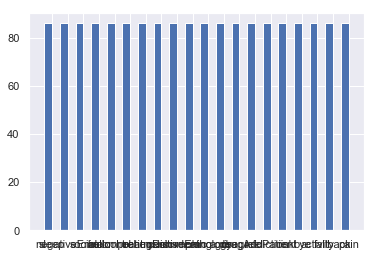

In [304]:
X_train,y_train=balanced_sample_maker(X,y)

In [305]:
pd.DataFrame([y_train.values, y_train.values]).T.groupby(0).count().sort_values(1).tail()

,1
0,
bye,86
alcohol,86
agree,86
social,86
treatment,86


In [306]:
y_train = y_train.fillna('hello')

In [307]:
bad_df = y.index.isin(y_train.index)
X_test = pd.DataFrame(X)[~bad_df]
y_test = data.loc[~bad_df]['intent']

In [308]:
from sklearn.svm import SVC

In [310]:
clf = SVC(kernel='linear', C=1, random_state=0, probability=True).fit(X_train, y_train)

In [311]:
clf.score(X_test, y_test)

0.0832807570977918

In [312]:
clf.predict(X_test[:40])

array(['drugAddiction', 'disagree', 'risk', 'risk', 'risk', 'disagree',
       'risk', 'risk', 'eatingDisorders', 'eatingDisorders', 'risk',
       'risk', 'risk', 'drugAddiction', 'disagree', 'sleep', 'risk',
       'eatingDisorders', 'eatingDisorders', 'risk', 'risk',
       'eatingDisorders', 'eatingDisorders', 'sleep', 'sleep', 'disagree',
       'eatingDisorders', 'disagree', 'disagree', 'eatingDisorders',
       'sleep', 'drugAddiction', 'eatingDisorders', 'drugAddiction',
       'risk', 'risk', 'risk', 'sleep', 'drugAddiction', 'sleep'],
      dtype=object)

In [313]:
from sklearn.model_selection import cross_val_score

In [314]:
cv_scores = cross_val_score(clf, X_test, y_test, cv=10) 

In [315]:
cv_scores

array([0.17964072, 0.18072289, 0.18181818, 0.18404908, 0.1835443 ,
       0.18589744, 0.18831169, 0.18954248, 0.19078947, 0.19205298])

In [316]:
print('{:2.3} + {:2.3}%'.format(np.mean(cv_scores), np.std(cv_scores)))

0.186 + 0.00414%


In [317]:
from sklearn.metrics import confusion_matrix

In [318]:
clf_res = pd.DataFrame([clf.predict(X_test), y_test]).T
clf_res.columns = ['class', 'intent']

In [319]:
cm = pd.DataFrame(confusion_matrix(clf_res['intent'], clf_res['class']), 
             index=clf.classes_, columns=clf.classes_)

In [320]:
clf_res.groupby('class').count()

,intent
class,
activity,1
alcohol,44
disagree,365
drugAddiction,211
eatingDisorders,390
negativeEmo,87
risk,221
sleep,252
social,14


In [321]:
clf_res.groupby('intent').count()

,class
intent,
activity,87
agree,24
alcohol,26
bye,24
disagree,23
drugAddiction,109
eatingDisorders,68
fallback,22
hello,24


In [322]:
cm.style.set_table_styles(
    [dict(selector="th",props=[('max-width', '120px')]),
        dict(selector="th.col_heading",
                 props=[("writing-mode", "vertical-rl"), 
                        ('transform', 'rotateZ(180deg)'),
                        ])]
).background_gradient(axis=0)

,activity,agree,alcohol,bye,disagree,drugAddiction,eatingDisorders,fallback,hello,incomprehension,infoPatient,negativeEmo,pain,pathology,positiveEmo,risk,sleep,smoking,social,treatment
activity,0,0,1,0,33,7,22,0,0,0,0,0,0,0,0,12,11,0,1,0
agree,0,0,0,0,4,0,5,0,0,0,0,7,0,0,0,2,6,0,0,0
alcohol,0,0,0,0,5,2,5,0,0,0,0,0,0,0,0,12,2,0,0,0
bye,0,0,0,0,10,1,6,0,0,0,0,4,0,0,0,0,2,0,1,0
disagree,0,0,0,0,15,0,4,0,0,0,0,1,0,0,0,0,1,0,2,0
drugAddiction,0,0,6,0,19,14,26,0,0,0,0,1,0,0,0,28,15,0,0,0
eatingDisorders,0,0,1,0,10,7,23,0,0,0,0,3,0,0,0,14,10,0,0,0
fallback,0,0,0,0,12,1,0,0,0,0,0,4,0,0,0,1,4,0,0,0
hello,0,0,0,0,11,3,7,0,0,0,0,0,0,0,0,3,0,0,0,0
incomprehension,0,0,3,0,16,2,3,0,0,0,0,0,0,0,0,1,8,0,0,0


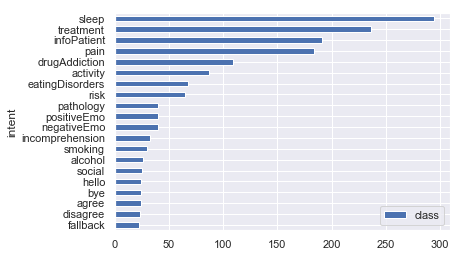

In [323]:
clf_res.groupby('intent').count().sort_values('class').plot(kind='barh')

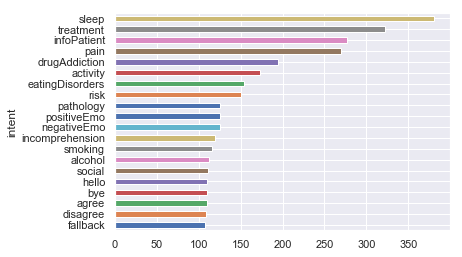

In [324]:
data.groupby('intent').count()['text'].sort_values().plot(kind='barh')

In [325]:
data.loc[0]

entities        [{'start': 34, 'end': 38, 'value': 'wine', 'en...
intent                                                    alcohol
text            I’m drinking at least a bottle of wine a day i...
clean_text               [drink, little, bottle, wine, day, week]
bow              [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]
len                                                             6
w2v_features    [-0.0018016292, 0.001879403, -0.0035352185, -0...
Name: 0, dtype: object

## Label new data

In [326]:
import json

In [327]:
posts = list(map(lambda x: x['post'], json.loads(open('subset.json', 'r').read())))[:100]

In [328]:
import spacy
nlp = spacy.blank('en')
nlp.add_pipe(nlp.create_pipe('sentencizer'))

In [329]:
import nltk,re

def get_good_tokens(sentence):
    stopwords = nltk.corpus.stopwords.words('english')+['pron']        
    
    replaced_punctation = list(map(lambda token: re.sub('[^0-9A-Za-z]+', '', token), sentence))
    replaced_numbers = list(map(lambda token: re.sub('[0-9]+', '_num_', token), replaced_punctation))
    removed_punctation = list(filter(lambda token: token, replaced_numbers))
    removed_stopwords = list(filter(lambda token: token not in stopwords, removed_punctation))
    return removed_stopwords

In [330]:
tokenized_posts = list(map(lambda post: 
                           list((get_good_tokens([token.text.lower() for token in sent]), sent)
                                for sent in nlp(post).sents), 
                    posts))

In [331]:
tokenized_posts = sum(tokenized_posts, [])

In [332]:
new_data = pd.DataFrame(tokenized_posts, columns=['clean_text', 'text'])

In [333]:
new_data.text = new_data.text.apply(lambda x: ' '.join([word.text for word in x]))

In [334]:
new_data['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), new_data.clean_text))

In [338]:
new_data['w2v_features'] = list(map(lambda sen_group:
                                  get_w2v_features(W2Vmodel, sen_group),
                                  new_data.text))

In [339]:
X_new_w2v = np.array(list(map(np.array, new_data.w2v_features)))

In [340]:
new_data['prediction'] = clf.predict(X_new_w2v)
new_data['proba'] = clf.predict_proba(X_new_w2v).max(axis=1)

In [341]:
new_data.sort_values('proba', ascending=False)

,clean_text,text,bow,w2v_features,prediction,proba
3170,[hello],Hello All !,"[(1430, 1)]","[-0.005443059, 0.0053257, -0.010130011, -0.004...",negativeEmo,0.053943
2637,[meds],\n\n meds ?,"[(512, 1)]","[-0.005443059, 0.0053257, -0.010130011, -0.004...",negativeEmo,0.053943
975,[kelly],\n Kelly,[],"[-0.005443059, 0.0053257, -0.010130011, -0.004...",negativeEmo,0.053943
5001,[hello],\n Hello !,"[(1430, 1)]","[-0.005443059, 0.0053257, -0.010130011, -0.004...",negativeEmo,0.053943
1835,"[god, bless]",\n\n God Bless \n A,[],"[-0.005443059, 0.0053257, -0.010130011, -0.004...",negativeEmo,0.053943
4631,"[taz, denat, hello]",\n\n Taz \n DenaT~ \n Hello !,"[(1430, 1)]","[-0.005308334, 0.005512731, -0.010349929, -0.0...",negativeEmo,0.053943
1505,[_num_],I am in my 50 's .,"[(27, 1)]","[2.5840807e-05, 0.00025544467, -0.0005359006, ...",disagree,0.053809
4211,[],\n I 'm not .,[],"[2.5840807e-05, 0.00025544467, -0.0005359006, ...",disagree,0.053809
3666,[nothing],Nothing ?,"[(1091, 1)]","[0.00010733723, 0.00017063487, 0.00023885166, ...",disagree,0.053797
3010,[long],"\n\n How long ? ,","[(255, 1)]","[0.00034551424, 0.00017683285, -9.809099e-05, ...",disagree,0.053795


In [342]:
data.intent.unique()

array(['alcohol', 'eatingDisorders', 'pathology', 'drugAddiction',
       'smoking', 'treatment', 'sleep', 'infoPatient', 'pain', 'activity',
       'incomprehension', 'negativeEmo', 'positiveEmo', 'fallback',
       'social', 'agree', 'disagree', 'hello', 'bye', 'risk'],
      dtype=object)

In [343]:
new_data[new_data.prediction == 'sleep']\
    .sort_values('proba', ascending=False)[['text', 'proba', 'clean_text']]

,text,proba,clean_text
3177,That helped a lot .,0.053535,"[helped, lot]"
2761,"I ended up with early menopause , osteoporos...",0.053520,"[ended, early, menopause, osteoporosis, etc]"
2607,\n\n I HOPE I have helped a bit .,0.053518,"[hope, helped, bit]"
3841,They might also have a temperature and a loss ...,0.053517,"[might, also, temperature, loss, appetite]"
4704,I went to a dr because by this time my periods...,0.053516,"[went, dr, time, periods, disappeared, complet..."
2959,"With the bags , they would have to be emptied ...",0.053514,"[bags, would, emptied, many, times, day]"
4607,Hoping that some of these changes could possib...,0.053513,"[hoping, changes, could, possible, help, symto..."
364,The police & PO showed up at school the next d...,0.053512,"[police, po, showed, school, next, day, dealt, w]"
4928,I 'll have to inquire to see if that 's possib...,0.053512,"[inquire, see, possible]"
2767,Vee P.S. There are others on this Board...,0.053512,"[vee, ps, others, board, discussed, persistent..."
